In [1]:
import torch
torch.set_num_threads(1)
import MiniFL as mfl

In [2]:
NUM_CLIENTS = 10
NUM_FEATURES = 300

In [3]:
def get_task():
    return mfl.tasks.get_w8a_regression_fns(
        data_path="w8a",
        num_clients=NUM_CLIENTS,
        batch_size=-1,
    )

In [4]:
GD_STEPS = 100

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_gd_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    gamma_multiplier=1,
)

GD_METRICS = mfl.algorithms.run_algorithm_with_processes(master, clients, GD_STEPS)

Process SpawnPoolWorker-4:
Traceback (most recent call last):
  File "/home/black_samorez/MiniFL/.conda/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/black_samorez/MiniFL/.conda/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/black_samorez/MiniFL/.conda/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/home/black_samorez/MiniFL/.conda/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/black_samorez/MiniFL/src/MiniFL/__init__.py", line 1, in <module>
    from . import algorithms, compressors, fn, tasks
  File "/home/black_samorez/MiniFL/src/MiniFL/algorithms/__init__.py", line 1, in <module>
    from . import cocktailsgd, gd, marina
  File "/home/black_samorez/MiniFL/src/MiniFL/algorithms/cocktailsgd.py", line 10, 

TimeoutError: 

In [ ]:
MARINA_STEPS = 1000

master_fn, client_fns = get_task()

master, clients = mfl.algorithms.get_marina_master_and_clients(
    master_fn=master_fn,
    client_fns=client_fns,
    compressors=[mfl.compressors.RandKUnbiasedCompressor(NUM_FEATURES, k=1) for _ in range(NUM_CLIENTS)],
    p=0.01,
    gamma_multiplier=1,
)

MARINA_METRICS = mfl.algorithms.run_algorithm_with_processes(master, clients, MARINA_STEPS)

  0%|          | 0/1000 [00:05<?, ?it/s]


KeyboardInterrupt: 

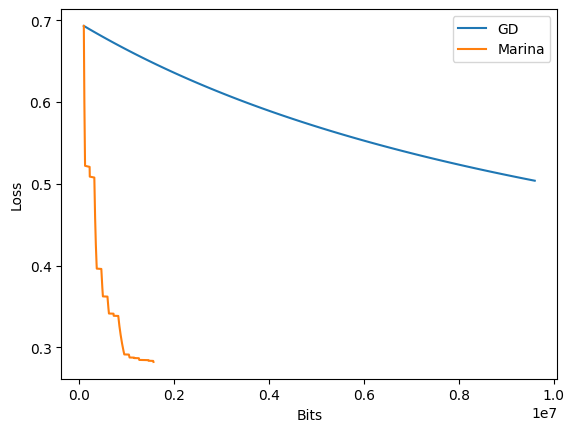

In [6]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received for metrics in GD_METRICS], [metrics.value for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received for metrics in MARINA_METRICS], [metrics.value for metrics in MARINA_METRICS], label="Marina")
# plt.plot([metrics.total_bits_received for metrics in COCKTAIL_METRICS], [metrics.value for metrics in COCKTAIL_METRICS], label="Cocktail")

plt.xlabel("Bits")
plt.ylabel("Loss")
plt.legend()

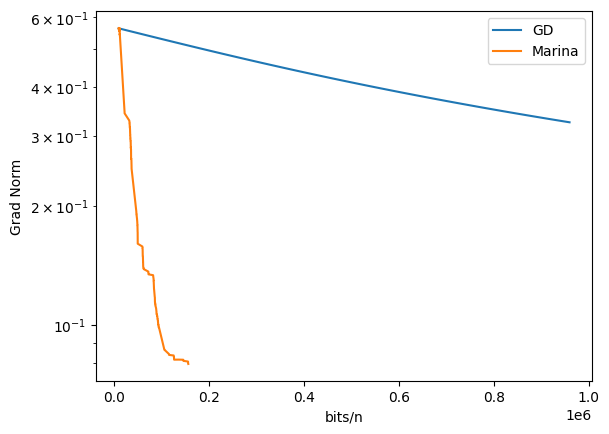

In [7]:
import matplotlib.pyplot as plt

plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in GD_METRICS], [metrics.grad_norm for metrics in GD_METRICS], label="GD")
plt.plot([metrics.total_bits_received/NUM_CLIENTS for metrics in MARINA_METRICS], [metrics.grad_norm for metrics in MARINA_METRICS], label="Marina")
plt.yscale("log")

plt.xlabel("bits/n")
plt.ylabel("Grad Norm")
plt.legend()